In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import sampler
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,2"
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from PIL import Image
import time

In [2]:
# specify dtype
use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())
print(use_cuda)

3
True


In [3]:
# Hyperparameters
batch_size = 64
learning_rate = 5e-3
momentum = 0.9
num_epoch = 25
pretrain = True
idp_ranges = [0.3, 0.5, 0.7, 1]

In [4]:
# Data
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

data_path = '/home/put_data/frank840925/IDP/data'
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     ])
trainset = torchvision.datasets.CIFAR100(root=data_path, 
                                        train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,num_workers=4)
valset = torchvision.datasets.CIFAR100(root=data_path, 
                                       train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,0),
                                       num_workers=4)
testset = torchvision.datasets.CIFAR100(root=data_path, 
                                       train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,
                                        num_workers=4)

print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000
10000
10000


In [5]:
# coeff_list = []
# for i, idp in enumerate(idp_ranges):
#     if i != len(idp_ranges)-1:
#         num_channel = int(C*(idp_ranges[i+1]-idp_ranges[i]))
#         channel_coeff = [idp_ranges[-(i+1)]]*num_channel
#         coeff_list.extend(channel_coeff)
#     else:
#         num_channel = C-len(coeff_list)
#         channel_coeff = [idp_ranges[-(i+1)]]*num_channel
#         coeff_list.extend(channel_coeff)        
# coeff_list = [[c] for c in coeff_list]
# print(coeff_list)

In [6]:
# Helper functions
def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="green", label="val")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Cross-entropy loss")
    #plt.savefig('output_losses.png')

def plot_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    if accuracy1:
        ax1.plot(accuracy1, color="red", label="train")
    if accuracy2:
        ax1.plot(accuracy2, color="black", label="val")
    plt.xlabel("epoch") 
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Train/Val accuracy") 
    #plt.savefig('accuracy.png')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([64, 3, 32, 32])


In [7]:
# self-defined modules(layers)
class Flatten(nn.Module):
    def forward(self, x):
        # read in N, C, H, W
        N, C, H, W = x.size()
        # flatten the C * H * W values into a single vector per image
        return x.view(N, -1)  
    
class idp_tensor(nn.Module):
    def __init__(self, idp):
        super(idp_tensor, self).__init__()
        self.idp = idp
    def forward(self, c):
        #input tensor c, size N*C*H*W, output with the same size, some channels zeroed according to idp
        N, C, H, W = c.size()
        non_zero_channel = int(C*(self.idp))
        zero_channels = C-non_zero_channel
        if zero_channels > 0:
            zeros = Variable(torch.zeros(zero_channels).view(zero_channels,1)).type(dtype) #C
            zeros = zeros.expand(zero_channels, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c = torch.cat([c[:, :non_zero_channel, :, :].clone(), zeros], 1).type(dtype)
            return c
        else:
            return c
        
class first_idp_tensor_4(nn.Module):
    def __init__(self, idp1=0.3, idp2=0.5, idp3=0.7, idp4=1):
        super(first_idp_tensor_4, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
        self.idp4 = idp4
    def forward(self, c):
        #input the first conv-Relu-Linear output, N*C*H*W, replicate and apply idp and concat in first dim (N)
        N, C, H, W = c.size()
        non_zero_channel_1 = int(C*(self.idp1))
        non_zero_channel_2 = int(C*(self.idp2))
        non_zero_channel_3 = int(C*(self.idp3))
        non_zero_channel_4 = int(C*(self.idp4))
        if C-non_zero_channel_1 > 0:
            zeros = Variable(torch.zeros(C-non_zero_channel_1).view(C-non_zero_channel_1,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_1, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c1 = torch.cat([c[:, :non_zero_channel_1, :, :].clone(), zeros], 1).type(dtype)
        else:
            c1 = c
        if C-non_zero_channel_2 > 0:
            zeros = Variable(torch.zeros(C-non_zero_channel_2).view(C-non_zero_channel_2,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_2, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c2 = torch.cat([c[:, :non_zero_channel_2, :, :].clone(), zeros], 1).type(dtype)
        else:
            c2 = c
        if C-non_zero_channel_3 > 0:
            zeros = Variable(torch.zeros(C-non_zero_channel_3).view(C-non_zero_channel_3,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_3, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c3 = torch.cat([c[:, :non_zero_channel_3, :, :].clone(), zeros], 1).type(dtype)
        else:
            c3 = c
        if C-non_zero_channel_4 > 0:
            zeros = Variable(torch.zeros(C-non_zero_channel_4).view(C-non_zero_channel_4,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_4, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c4 = torch.cat([c[:, :non_zero_channel_4, :, :].clone(), zeros], 1).type(dtype)
        else:
            c4 = c
        out = torch.cat([c1, c2, c3, c4], 0)
        return out
        
class middle_idp_tensor_4(nn.Module):
    def __init__(self, idp1=0.3, idp2=0.5, idp3=0.7, idp4=1):
        super(middle_idp_tensor_4, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
        self.idp4 = idp4
    def forward(self, c):
        #input a middle conv-Relu-Linear output, (3*N)*C*H*W, apply IDP1, IDP2, IDP3 to each
        NN, C, H, W = c.size()
        if NN>=4:
            N = int(NN/4)
            non_zero_channel_1 = int(C*(self.idp1))
            non_zero_channel_2 = int(C*(self.idp2))
            non_zero_channel_3 = int(C*(self.idp3))
            non_zero_channel_4 = int(C*(self.idp4))
            c1 = c[:N,:,:,:]
            c2 = c[N:2*N,:,:,:]
            c3 = c[2*N:3*N,:,:,:]
            c4 = c[3*N:,:,:,:]
            if C-non_zero_channel_1 > 0:
                zeros = Variable(torch.zeros(C-non_zero_channel_1).view(C-non_zero_channel_1,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_1, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c1 = torch.cat([c1[:, :non_zero_channel_1, :, :].clone(), zeros], 1).type(dtype)
            else:
                c1 = c1
            if C-non_zero_channel_2 > 0:
                zeros = Variable(torch.zeros(C-non_zero_channel_2).view(C-non_zero_channel_2,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_2, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c2 = torch.cat([c2[:, :non_zero_channel_2, :, :].clone(), zeros], 1).type(dtype)
            else:
                c2 = c2
            if C-non_zero_channel_3 > 0:
                zeros = Variable(torch.zeros(C-non_zero_channel_3).view(C-non_zero_channel_3,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_3, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c3 = torch.cat([c3[:, :non_zero_channel_3, :, :].clone(), zeros], 1).type(dtype)
            else:
                c3 = c3
            if C-non_zero_channel_4 > 0:
                zeros = Variable(torch.zeros(C-non_zero_channel_4).view(C-non_zero_channel_4,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_4, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c4 = torch.cat([c4[:, :non_zero_channel_4, :, :].clone(), zeros], 1).type(dtype)
            else:
                c4 = c4
            out = torch.cat([c1, c2, c3, c4],0)
            return out
        else:
            return c

class func_linear(nn.Module):
    def __init__(self, k=1):
        super(func_linear, self).__init__()
        self.k = k
    def channel_coeff(self, N, C, H, W):
        coeff_list = list(map(lambda a: 1-(a/(C+1)), range(0,C)))
        coeff_list = [[c] for c in coeff_list]
        coeff = Variable(torch.Tensor(coeff_list)).type(dtype) #C
        coeff_tensor = coeff.expand(C,H) #C*H
        coeff_tensor = torch.stack([coeff_tensor]*W,1) #C*H*W
        coeff_tensor = torch.stack(([coeff_tensor]*N)) #N*C*H*W
        return coeff_tensor

    def forward(self, x):
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), self.channel_coeff(N, C, H, W))
        return x
    
class func_impulse(nn.Module):
    def __init__(self, bound=0.3, high_value = 1, low_value = 0.2):
        super(func_impulse, self).__init__()
        self.bound = bound
        self.high_value = high_value
        self.low_value = low_value
    def channel_coeff(self, N, C, H, W):
        pri_channel = int(C*self.bound)
        pri_channel_coeff = [self.high_value]*pri_channel
        non_pri_channel = C-pri_channel
        non_pri_channel_coeff = [self.low_value]*non_pri_channel
        coeff_list = pri_channel_coeff+non_pri_channel_coeff
        coeff_list = [[c] for c in coeff_list]
        
        coeff = Variable(torch.Tensor(coeff_list)).type(dtype) #C
        coeff_tensor = coeff.expand(C,H) #C*H
        coeff_tensor = torch.stack([coeff_tensor]*W,1) #C*H*W
        coeff_tensor = torch.stack(([coeff_tensor]*N)) #N*C*H*W
        return coeff_tensor

    def forward(self, x):
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), self.channel_coeff(N, C, H, W))
        return x

class func_steps(nn.Module):
    def __init__(self, idp_ranges=idp_ranges):
        super(func_steps, self).__init__()
        self.idp_ranges = idp_ranges
    def channel_coeff(self, N, C, H, W):
        coeff_list = []
        for i, idp in enumerate(self.idp_ranges):
            if i != len(self.idp_ranges)-1:
                num_channel = int(C*(self.idp_ranges[i+1]-self.idp_ranges[i]))
                channel_coeff = [self.idp_ranges[-(i+1)]]*num_channel
                coeff_list.extend(channel_coeff)
            else:
                num_channel = C-len(coeff_list)
                channel_coeff = [self.idp_ranges[-(i+1)]]*num_channel
                coeff_list.extend(channel_coeff)        
        coeff_list = [[c] for c in coeff_list]
        coeff = Variable(torch.Tensor(coeff_list)).type(dtype) #C
        coeff_tensor = coeff.expand(C,H) #C*H
        coeff_tensor = torch.stack([coeff_tensor]*W,1) #C*H*W
        coeff_tensor = torch.stack(([coeff_tensor]*N)) #N*C*H*W
        return coeff_tensor

    def forward(self, x):
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), self.channel_coeff(N, C, H, W))
        return x
    
class func_harmonic(nn.Module):
    #perform element-wise multiplication to channels in x with coefficient k/n, n is channel index
    def __init__(self, k=1):
        super(func_harmonic, self).__init__()
        self.k = k
    def channel_coeff(self, N, C, H, W):
        #C is channels, return a list with corresponding index: [k, k/2,...]
        #returns a tensor with size N*C*H*W
        coeff = list(map(lambda a: self.k/a, range(1,C+1)))
        tensor_list = []
        for c in coeff:
            coeff_tensor = torch.ones(H, W)
            coeff_tensor = torch.mul(coeff_tensor, c)
            tensor_list.append(coeff_tensor)
        ct = torch.stack(tensor_list, 0)
        ct = torch.stack(([ct]*N))
        return ct
    
    def forward(self, x):
        #x is an input tensor, size N*C*H*W
        #for cnn, functions are applied to each filter
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), Variable(self.channel_coeff(N, C, H, W), requires_grad=False).type(dtype))
        return x

In [8]:
class tesla_coef_idp_VGG_4branch(nn.Module):
    def __init__(self, idp_layers, model=models.vgg16_bn(pretrained=pretrain).type(dtype), idp1=0.3, idp2=0.5, idp3=0.7, idp4=1):
        #idp is 0~1, idp_layers is a set, specify which layer in features should apply idp
        #now idp_layers is 3,6,8,11,13,15,18,20,22,25,27,29
        super(tesla_coef_idp_VGG_4branch, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
        self.idp4 = idp4
        self.idp_layers = idp_layers
        self.features = nn.Sequential(*(self.new_features_list(model)))
        self.classifier = nn.Sequential(nn.Linear(512, 512),
                              nn.ReLU(inplace=True),
                              nn.Dropout(0.5),
                              nn.Linear(512, 100))
    
    def new_features_list(self, model):
        new_layers = []
        #create from pre-trained resnet
        for i, layer in enumerate(list(model.features.children())):
            #if i ==1: non-bn
            if i==2:
                new_layers.append(layer)
                #new_layers.append(func_linear())
                new_layers.append(func_impulse())
                new_layers.append(first_idp_tensor_4(self.idp1, self.idp2, self.idp3, self.idp4))
            elif i not in self.idp_layers:
                new_layers.append(layer)                
            else:
                new_layers.append(layer)
                #new_layers.append(func_linear())
                new_layers.append(func_impulse())
                new_layers.append(middle_idp_tensor_4(self.idp1, self.idp2, self.idp3, self.idp4))
        new_layers.append(Flatten())
        return new_layers        
    
    def forward(self, x):
        f = self.features(x)
        NN, M = f.size()
        N = int(NN/4)
        o1 = f[:N, :]
        o2 = f[N:2*N, :]
        o3 = f[2*N:3*N,:]
        o4 = f[3*N:,:]
        o1 = self.classifier(o1)
        o2 = self.classifier(o2)
        o3 = self.classifier(o3)
        o4 = self.classifier(o4)
        return o1, o2, o3, o4

In [9]:
# find all relu layers to add idp layer
model = models.vgg16_bn(pretrained=pretrain).type(dtype)
idp_layers = set()
for i, layer in model.features.named_children():
    if str(layer) in ['ReLU(inplace)', 'ReLU']:
        idp_layers.add(int(i))
print(idp_layers)
idp_layers.remove(min(idp_layers)) #remove first relu layer
print(idp_layers)

{32, 2, 36, 5, 39, 9, 42, 12, 16, 19, 22, 26, 29}
{32, 36, 5, 39, 9, 42, 12, 16, 19, 22, 26, 29}


In [10]:
# test the model by forward pass, output size
# net = tesla_coef_idp_VGG_4branch(idp_layers).type(dtype)
# net = torch.nn.DataParallel(net)

# x = Variable(torch.randn(32, 3, 32, 32)).type(dtype)
# out1, out2, out3, out4 = net(x)
# print(out1.size())
# print(out2.size())
# print(out3.size())
# print(out4.size())

In [11]:
#net

In [12]:
# early stopping fuction
def early_stop(val_loss,  patience=10):
    if len(val_loss)<patience:
        return False
    p = 0
    for i in range(1, patience+1):
        if val_loss[-1] - val_loss[-1-i]>=0:
            p=p+1
    if p>=patience:
        return True
    else:
        return False

In [13]:
def train_tesla_4(num_epoch, net, criterion, optimizer, scheduler, alpha1=0, alpha2=0, alpha3=0, alpha4=1, index=3):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    max_val_acc = 0

    # start training
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss1 = []
        running_loss2 = []
        running_correct1=[]
        running_correct2=[]
        tStart = time.time()
        for i, data in enumerate(trainloader, 0):
            correct = 0
            net.train(True)
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss1 = criterion(outputs[0], labels) #idp-low
            loss2 = criterion(outputs[1], labels) #idp-mid1
            loss3 = criterion(outputs[2], labels) #idp-mid2
            loss4 = criterion(outputs[3], labels) #idp-high
            
            #adjust alpha 
            #alpha1 = loss1/(loss1+loss2+loss3)
            #alpha2 = loss2/(loss1+loss2+loss3)
            #alpha3 = loss3/(loss1+loss2+loss3)
            
            loss = alpha1*loss1+alpha2*loss2+alpha3*loss3+alpha4*loss4
            
            loss.backward()
            optimizer.step()
            # print statistics
            # loss
            running_loss1.append(loss.data[0])
            # accuracy
            _, predicted = torch.max(outputs[index].data, 1)
            correct += (predicted == labels.data).sum()
            correct = correct/labels.size(0)*100
            running_correct1.append(correct)

        for i, tdata in enumerate(valloader, 0):
            test_correct = 0
            net.train(False)
            tinputs, tlabels = tdata
            tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
            toutputs = net(tinputs)
            tloss1 = criterion(toutputs[0], tlabels)
            tloss2 = criterion(toutputs[1], tlabels)
            tloss3 = criterion(toutputs[2], tlabels)
            tloss4 = criterion(toutputs[3], tlabels)
            
            tloss = alpha1*tloss1+alpha2*tloss2+alpha3*loss3+alpha4*loss4
            
            running_loss2.append(tloss.data[0])
            _, tpredicted = torch.max(toutputs[index].data, 1)
            test_correct += (tpredicted == tlabels.data).sum()
            test_correct = test_correct/tlabels.size(0)*100
            running_correct2.append(test_correct)
            
        scheduler.step(np.mean(running_loss2))

        train_loss.append(np.mean(running_loss1))
        test_loss.append(np.mean(running_loss2))
        train_acc.append(np.mean(running_correct1))
        test_acc.append(np.mean(running_correct2))
        tEnd = time.time()
        
        #save best model
        if np.mean(running_correct2) > max_val_acc:
            max_val_acc = np.mean(running_correct2)
            torch.save(net.state_dict(), 'saved_models/100_70_50_30_tesla_large_impulse_idp_model_cifar100_2.pkl')

        #statistics
        print('Epoch[%d/%d], Train Loss:%.2f, Val Loss:%.2f, Train Acc:%.2f%%, Val Acc:%.2f%%, Time:%.1fs' 
                    %(epoch+1, num_epoch, train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1], (tEnd - tStart)))
        #early stopping
        if epoch > 8:
            if early_stop(test_loss, 7):
                print('Early stopping')
                break
            else:
                continue
        
    print('Finished Training')
    return train_loss, test_loss, train_acc, test_acc

In [14]:
# define models, optimizers, training
all_train_loss = []
all_test_loss = []
all_train_acc = []
all_test_acc = []

criterion = nn.CrossEntropyLoss()
net = tesla_coef_idp_VGG_4branch(idp_layers, idp1=idp_ranges[0], idp2=idp_ranges[1], idp3=idp_ranges[2], idp4=idp_ranges[3]).type(dtype)
net = torch.nn.DataParallel(net)

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-6)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

train_loss, test_loss, train_acc, test_acc = train_tesla_4(num_epoch, net, criterion, optimizer, scheduler,
                                                                   alpha1=0.1, alpha2=0.1, alpha3=0.1, alpha4=0.7,index=3)
all_train_loss.extend(train_loss)
all_test_loss.extend(test_loss)
all_train_acc.extend(train_acc)
all_test_acc.extend(test_acc)

train_loss, test_loss, train_acc, test_acc = train_tesla_4(num_epoch, net, criterion, optimizer, scheduler,
                                                                   alpha1=0.3, alpha2=0.3, alpha3=0.2, alpha4=0.2,index=3)
all_train_loss.extend(train_loss)
all_test_loss.extend(test_loss)
all_train_acc.extend(train_acc)
all_test_acc.extend(test_acc)

Epoch[1/25], Train Loss:4.18, Val Loss:3.68, Train Acc:7.88%, Val Acc:17.21%, Time:147.7s
Epoch[2/25], Train Loss:2.99, Val Loss:2.53, Train Acc:25.59%, Val Acc:37.44%, Time:123.6s
Epoch[3/25], Train Loss:2.39, Val Loss:2.13, Train Acc:39.28%, Val Acc:45.45%, Time:123.9s
Epoch[4/25], Train Loss:2.07, Val Loss:2.17, Train Acc:47.74%, Val Acc:50.81%, Time:123.6s
Epoch[5/25], Train Loss:1.84, Val Loss:1.74, Train Acc:53.74%, Val Acc:54.71%, Time:125.6s
Epoch[6/25], Train Loss:1.66, Val Loss:1.60, Train Acc:58.54%, Val Acc:56.76%, Time:124.3s
Epoch[7/25], Train Loss:1.53, Val Loss:1.82, Train Acc:62.28%, Val Acc:57.20%, Time:124.0s
Epoch[8/25], Train Loss:1.41, Val Loss:1.36, Train Acc:65.52%, Val Acc:58.58%, Time:124.1s
Epoch[9/25], Train Loss:1.31, Val Loss:1.69, Train Acc:68.04%, Val Acc:60.68%, Time:123.7s
Epoch[10/25], Train Loss:1.22, Val Loss:1.35, Train Acc:70.74%, Val Acc:61.00%, Time:125.0s
Epoch[11/25], Train Loss:1.13, Val Loss:1.26, Train Acc:73.38%, Val Acc:62.66%, Time:127.6

In [15]:
# for index, idp in enumerate(idp_ranges):
#     if index == 0:
#         print('train with idp4')
#         train_loss, test_loss, train_acc, test_acc = train_tesla_4(num_epoch, net, criterion, optimizer, scheduler,
#                                                                    alpha1=0, alpha2=0, alpha3=0, alpha4=1,index=3)
#         all_train_loss.extend(train_loss)
#         all_test_loss.extend(test_loss)
#         all_train_acc.extend(train_acc)
#         all_test_acc.extend(test_acc)
#     elif index ==1:
#         print('train with idp3')
#         train_loss, test_loss, train_acc, test_acc = train_tesla_4(num_epoch, net, criterion, optimizer, scheduler,
#                                                                    alpha1=0.1, alpha2=0.1, alpha3=0.5, alpha4=0.3, index=2)        
#         all_train_loss.extend(train_loss)
#         all_test_loss.extend(test_loss)
#         all_train_acc.extend(train_acc)
#         all_test_acc.extend(test_acc)
#     elif index ==2:
#         print('train with idp2')
#         train_loss, test_loss, train_acc, test_acc = train_tesla_4(num_epoch, net, criterion, optimizer, scheduler,
#                                                                    alpha1=0.1, alpha2=0.5, alpha3=0.2, alpha4=0.2, index=1)        
#         all_train_loss.extend(train_loss)
#         all_test_loss.extend(test_loss)
#         all_train_acc.extend(train_acc)
#         all_test_acc.extend(test_acc)
#     else:
#         print('train with idp1')
#         train_loss, test_loss, train_acc, test_acc = train_tesla_4(num_epoch, net, criterion, optimizer, scheduler,
#                                                                    alpha1=0.5, alpha2=0.2, alpha3=0.2, alpha4=0.1, index=0)        
#         all_train_loss.extend(train_loss)
#         all_test_loss.extend(test_loss)
#         all_train_acc.extend(train_acc)
#         all_test_acc.extend(test_acc)

In [16]:
# Save the last step Model
torch.save(net.state_dict(), 'saved_models/100_70_50_30_tesla_large_impulse_idp_model_cifar100_2_final.pkl')

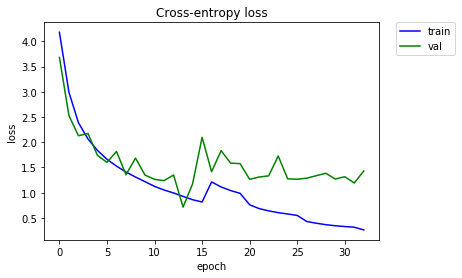

In [16]:
plot_losses(all_train_loss, all_test_loss)

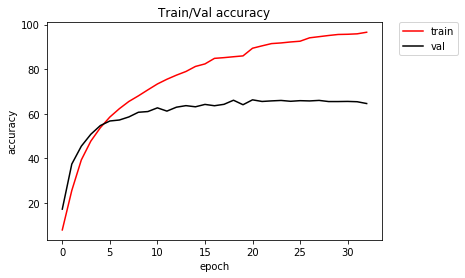

In [17]:
plot_accuracy(all_train_acc, all_test_acc)

In [18]:
def test_acccuracy(testloader, model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs1, outputs2, outputs3, outputs4  = model.forward(Variable(images, volatile=True).type(dtype))
        labels = Variable(labels, volatile=True).type(torch.cuda.LongTensor)
        _, predicted = torch.max(outputs4.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    acc = 100*correct/total
    print('Accuracy of the network with IDP on the test images: %d %%' % (acc))
    return acc

In [19]:
idp_acc_history = []
idp_harmonic_history = [0]*20

idp_scale = list(map(lambda x: x/20,range(1,21)))
print(idp_scale)
for i in idp_scale:
    net_inference = tesla_coef_idp_VGG_4branch(idp_layers, idp1=1, idp2=1, idp3=1, idp4=i).type(dtype)
    net_inference = torch.nn.DataParallel(net_inference)
    net_inference.load_state_dict(torch.load('saved_models/100_70_50_30_tesla_large_impulse_idp_model_cifar100_2.pkl'))
    a = test_acccuracy(testloader, net_inference.eval())
    idp_acc_history.append(a)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Accuracy of the network with IDP on the test images: 1 %
Accuracy of the network with IDP on the test images: 1 %
Accuracy of the network with IDP on the test images: 1 %
Accuracy of the network with IDP on the test images: 1 %
Accuracy of the network with IDP on the test images: 1 %
Accuracy of the network with IDP on the test images: 57 %
Accuracy of the network with IDP on the test images: 56 %
Accuracy of the network with IDP on the test images: 55 %
Accuracy of the network with IDP on the test images: 57 %
Accuracy of the network with IDP on the test images: 61 %
Accuracy of the network with IDP on the test images: 61 %
Accuracy of the network with IDP on the test images: 59 %
Accuracy of the network with IDP on the test images: 61 %
Accuracy of the network with IDP on the test images: 64 %
Accuracy of the network with IDP on the test images: 63 %
Accuracy of the network 

In [19]:
idp_acc_history

[1.0,
 1.0,
 0.99,
 0.93,
 1.95,
 59.79,
 57.41,
 53.56,
 56.06,
 62.91,
 61.86,
 61.22,
 62.11,
 64.15,
 63.81,
 62.28,
 62.6,
 64.08,
 64.98,
 66.2]

In [20]:
twostage_tesla_impulse_1117_3322_weightdecay = [1.0,
 1.0,
 1.0,
 0.99,
 1.62,
 57.99,
 57.08,
 53.14,
 56.31,
 61.4,
 61.28,
 60.78,
 61.15,
 64.4,
 64.22,
 64.01,
 63.25,
 64.16,
 65.26,
 66.6]

In [21]:
ag_loss_impulse3322_sgd_weightdecay = [1.0,
 1.0,
 1.0,
 0.64,
 2.41,
 57.3,
 57.38,
 57.25,
 56.92,
 58.91,
 58.43,
 58.47,
 58.61,
 58.88,
 58.38,
 58.71,
 58.59,
 59.06,
 58.64,
 58.99]

In [22]:
ag_loss_impulse_304050100_3223 = [1.0,
 1.0,
 0.74,
 1.0,
 1.68,
 54.22,
 52.9,
 55.42,
 55.5,
 56.14,
 48.15,
 36.83,
 23.17,
 16.77,
 22.43,
 33.19,
 45.39,
 55.14,
 59.87,
 65.3]

In [23]:
ag_loss_impulse3322 = [1.0,
 1.0,
 1.0,
 1.0,
 1.64,
 54.1,
 52.41,
 50.34,
 51.91,
 57.83,
 56.44,
 56.34,
 57.1,
 59.61,
 58.64,
 57.47,
 58.39,
 60.04,
 60.31,
 62.5]

In [24]:
Jimmy_2 = [1.0,
 1.0,
 1.0,
 0.84,
 1.35,
 39.11,
 25.37,
 16.45,
 23.75,
 60.56,
 56.26,
 56.4,
 59.05,
 64.51,
 63.68,
 63.34,
 63.79,
 64.26,
 64.91,
 65.51]

In [25]:
idp_acc_history_agg = [1.0,
 1.07,
 1.0,
 1.01,
 1.26,
 53.76,
 43.92,
 41.73,
 46.45,
 58.29,
 57.3,
 57.14,
 58.08,
 60.13,
 59.67,
 59.25,
 59.57,
 60.22,
 60.98,
 61.68]

In [26]:
steps = [1.0,
 1.0,
 1.0,
 1.0,
 1.25,
 48.28,
 6.3,
 13.26,
 27.0,
 59.47,
 53.8,
 53.18,
 57.76,
 62.39,
 62.29,
 62.2,
 62.24,
 63.41,
 64.03,
 64.86]

In [27]:
impulse = [1.0,
 1.07,
 1.0,
 1.01,
 1.26,
 53.76,
 43.92,
 41.73,
 46.45,
 58.29,
 57.3,
 57.14,
 58.08,
 60.13,
 59.67,
 59.25,
 59.57,
 60.22,
 60.98,
 61.68]

In [28]:
ag_loss_linear_4 = [1.0,
 1.0,
 1.0,
 1.0,
 1.02,
 46.34,
 7.06,
 9.15,
 18.94,
 60.18,
 55.55,
 53.46,
 59.89,
 63.11,
 62.72,
 63.12,
 63.02,
 63.24,
 63.66,
 63.53]

In [29]:
two_stage = [1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 51.12,
 20.02,
 10.3,
 25.89,
 60.69,
 54.47,
 47.17,
 46.31,
 45.68,
 50.39,
 48.9,
 48.66,
 49.55,
 49.66,
 49.42]

In [30]:
alpha =[1.0,
 1.0,
 1.0,
 1.0,
 0.9,
 1.26,
 1.77,
 1.47,
 4.97,
 61.78,
 56.73,
 52.75,
 58.39,
 61.88,
 64.32,
 64.18,
 63.73,
 64.44,
 65.15,
 64.93]

In [31]:
middle_weightd_ag_loss = [1.0,
 1.0,
 1.0,
 1.0,
 0.9,
 1.26,
 1.77,
 1.47,
 4.97,
 61.78,
 56.73,
 52.75,
 58.39,
 61.88,
 64.32,
 64.18,
 63.73,
 64.44,
 65.15,
 64.93]

In [32]:
ag_loss = [1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.57,
 1.02,
 1.51,
 5.01,
 61.26,
 53.4,
 49.92,
 55.64,
 60.66,
 65.29,
 65.1,
 65.95,
 66.12,
 66.73,
 67.09]

In [33]:
tesla = [1.0,
 1.0,
 1.0,
 1.0,
 0.84,
 0.97,
 1.0,
 1.96,
 4.5,
 62.01,
 51.33,
 47.21,
 55.26,
 59.79,
 66.25,
 65.02,
 65.53,
 65.89,
 66.4,
 67.14]

In [34]:
profile = [1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.82,
 1.39,
 1.7,
 3.63,
 34.04,
 44.06,
 47.91,
 54.34,
 57.4,
 58.47,
 61.17,
 62.75,
 62.85,
 63.33,
 63.68]

In [35]:
all_one_acc_history = [1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99,
 1.0,
 1.01,
 1.13,
 2.66,
 2.14,
 4.91,
 11.27,
 32.01,
 56.83,
 70.51]

In [36]:
linear_history = [1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.31,
 1.09,
 1.51,
 3.22,
 6.14,
 16.31,
 26.74,
 37.35,
 50.08,
 61.1,
 65.89,
 67.36,
 68.66]

In [37]:
def plot_idp_accuracy(accuracy1=None, accuracy2=None, accuracy3=None, accuracy4=None, accuracy5=None, accuracy6=None,
                     accuracy7=None, accuracy8=None, accuracy9=None, accuracy10=None):
    plt.clf()
    fig4 = plt.figure()
    ax1 = fig4.add_subplot(111)
    idp_scale = list(map(lambda x: x/20,range(1,21)))
    idp_scale_i = [i for i in range(0, len(idp_scale))]
    if accuracy1:
        ax1.plot(idp_scale_i, accuracy1, marker='s', linestyle='-', color='r', label="all-one")
    if accuracy2:
        ax1.plot(idp_scale_i, accuracy2, marker='o', linestyle='--', color='g', label="Linear")
    if accuracy3:
        ax1.plot(idp_scale_i, accuracy3, marker='o', linestyle='--', color='b', label="Profile-Linear")
    if accuracy4:
        ax1.plot(idp_scale_i, accuracy4, marker='o', linestyle='--', color='gray', label="Tesla-100-75-50-Linear")
    if accuracy5:
        ax1.plot(idp_scale_i, accuracy5, marker='o', linestyle='--', color='y', label="ag-loss1-100-75-50-Linear")
    if accuracy6:
        ax1.plot(idp_scale_i, accuracy6, marker='o', linestyle='--', color='purple', label="ag-loss2-100-75-50-Linear")
    if accuracy7:
        ax1.plot(idp_scale_i, accuracy7, marker='o', linestyle='--', color='pink', label="2stage_tesla-100-70-50-30-impulse-weightdecay_2")
    if accuracy8:
        ax1.plot(idp_scale_i, accuracy8, marker='o', linestyle='--', color='orange', label="ag-loss-100-70-50-30-impulse")
    if accuracy9:
        ax1.plot(idp_scale_i, accuracy9, marker='o', linestyle='--', color='aqua', label="ag-loss-100-70-50-30-steps")
    if accuracy10:
        ax1.plot(idp_scale_i, accuracy10, marker='o', linestyle='--', color='olive', label="2stage_tesla-100-70-50-30-impulse-weightdecay")
    plt.xticks(idp_scale_i, idp_scale)
    plt.xlabel("IDP") 
    plt.ylabel("Accuracy(%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Pretrained VGG16 with BN (CIFAR-100)") 
    #plt.savefig('results_graphs/tesla_3branch_linear_idp_accuracy.png')

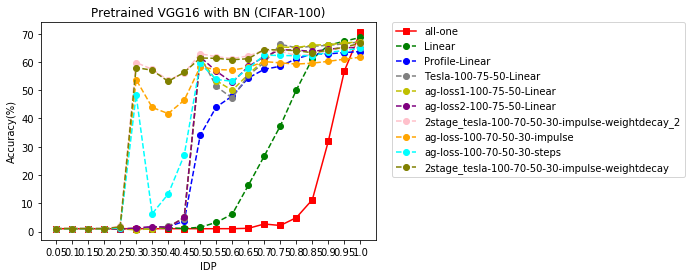

In [38]:
plot_idp_accuracy(all_one_acc_history,linear_history, profile, tesla, ag_loss, middle_weightd_ag_loss, idp_acc_history, impulse, steps, twostage_tesla_impulse_1117_3322_weightdecay)

In [ ]:
%%javascript
Jupyter.notebook.session.delete();